In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# !pip install nibabel
!pip install monai



     |████████████████████████████████| 584 kB 827 kB/s eta 0:00:01


In [85]:
import logging
import os
import sys
import tempfile
from glob import glob

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

import monai
from monai.data import create_test_image_3d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
)
from monai.visualize import plot_2d_or_3d_image

In [5]:
training_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
testing_path = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

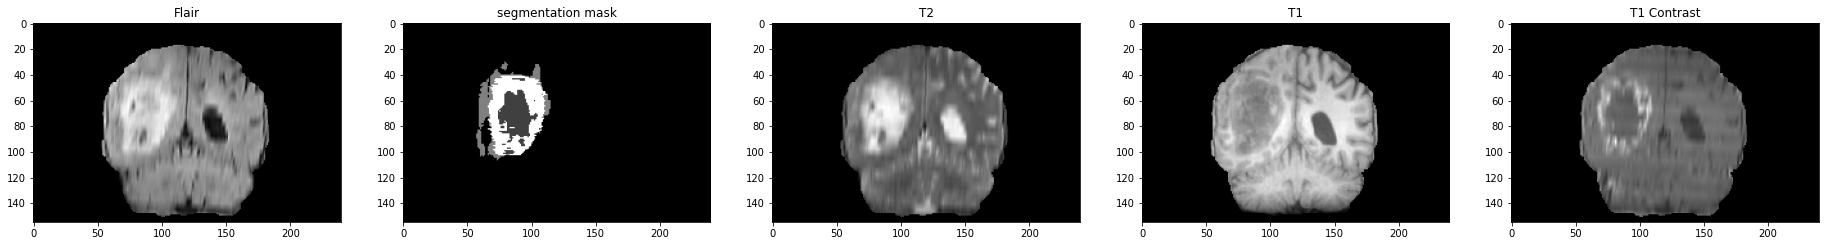



After scaling




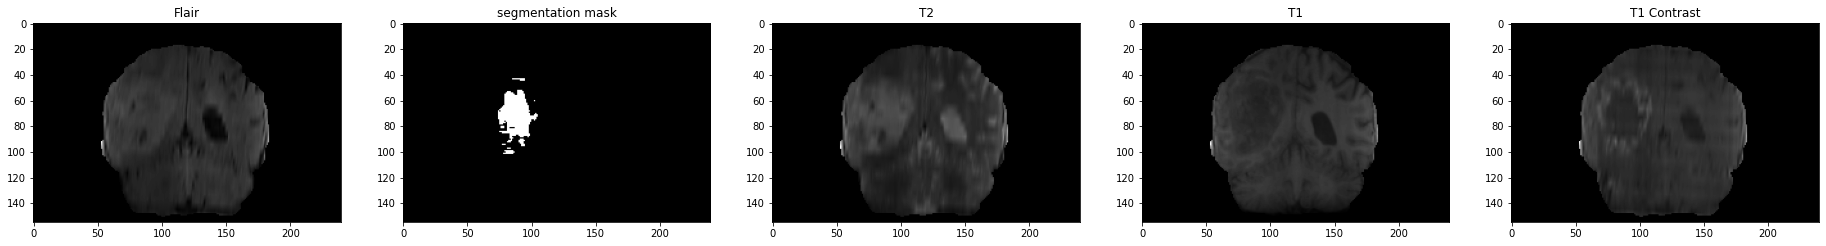

In [131]:
slice_number= 160
img_number = str(np.random.choice(355)).zfill(3)
flair_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_flair.nii").get_fdata()
seg_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_seg.nii").get_fdata()
t2_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_t2.nii").get_fdata()
t1_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_t1.nii").get_fdata()
t1ce_img_data = nib.load(training_path+"BraTS20_Training_"+img_number+"/BraTS20_Training_"+img_number+"_t1ce.nii").get_fdata()


plt.figure(figsize=(32,16))
plt.subplot(1,5,1)
plt.title("Flair")
plt.imshow(np.rot90(flair_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,2)
plt.title("segmentation mask")
plt.imshow(np.rot90(seg_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,3)
plt.title("T2")
plt.imshow(np.rot90(t2_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,4)
plt.title("T1")
plt.imshow(np.rot90(t1_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,5)
plt.title("T1 Contrast")
plt.imshow(np.rot90(t1ce_img_data[:,slice_number,:]),cmap='gray')
plt.show()

scalar = Normalizer()
normalized_flair_img_data =scalar.fit_transform(flair_img_data.reshape(-1, flair_img_data.shape[-1])).reshape(flair_img_data.shape)
normalized_seg_img_data= seg_img_data.astype(np.uint8)
normalized_t2_img_data =scalar.fit_transform(t2_img_data.reshape(-1, t2_img_data.shape[-1])).reshape(t2_img_data.shape)
normalized_t1_img_data =scalar.fit_transform(t1_img_data.reshape(-1, t1_img_data.shape[-1])).reshape(t1_img_data.shape) 
normalized_t1ce_img_data =scalar.fit_transform(t1ce_img_data.reshape(-1, t1ce_img_data.shape[-1])).reshape(t1ce_img_data.shape)

print("\n\nAfter scaling\n\n")

normalized_seg_img_data[normalized_seg_img_data > 1] = 0

plt.figure(figsize=(32,16))
plt.subplot(1,5,1)
plt.title("Flair")
plt.imshow(np.rot90(normalized_flair_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,2)
plt.title("segmentation mask")
plt.imshow(np.rot90(normalized_seg_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,3)
plt.title("T2")
plt.imshow(np.rot90(normalized_t2_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,4)
plt.title("T1")
plt.imshow(np.rot90(normalized_t1_img_data[:,slice_number,:]),cmap='gray')
plt.subplot(1,5,5)
plt.title("T1 Contrast")
plt.imshow(np.rot90(normalized_t1ce_img_data[:,slice_number,:]),cmap='gray')
plt.show()

In [128]:
np.sum(normalized_seg_img_data > 1)


26937

In [83]:
images = []
masks = []
for dirname, _, filenames in os.walk(training_path):
    for filename in filenames:
        if "_flair.nii" in filename:
            if "BraTS20_Training_355_flair.nii" not in filename:
            images.append(os.path.join(dirname, filename))
        if "seg.nii" in filename:
            masks.append(os.path.join(dirname, filename))
        
            
            
print("# of images: ", len(images), "\n# of masks",len(masks) )

image_number =np.random.randint(0,367)
print("image:\n", sorted(images)[image_number],"\nmask:\n ",sorted(masks)[image_number])

# of images:  368 
# of masks 368
image:
 ../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_051/BraTS20_Training_051_flair.nii 
mask:
  ../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_051/BraTS20_Training_051_seg.nii


In [136]:
class ImageAndSegmentationMaskDataset(Dataset):
    def __init__(self, img_seg_file_names, transform=None):
        self.transform = transform
        self.img_seg_file_names = img_seg_file_names
    def __len__(self):
        return len(self.img_seg_file_names)
    
    def __getitem__(self,index):
        img_path = self.img_seg_file_names[index]['img']
        seg_path = self.img_seg_file_names[index]['seg']
        img = nib.load(img_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()
        
        seg[seg>1] = 0
        
        if self.transform:
            img = self.transform(img)
            
            
        return {img, seg}
        
        

In [137]:
dataset = ImageAndSegmentationMaskDataset(img_seg_file_names)
len(dataset)

368

In [89]:
images = sorted(images)
masks = sorted(masks)
img_seg_file_names = []
for img, seg in zip(images, masks):
    img_seg_file_names.append({'img': img, "seg": seg})
    
img_seg_file_names

[{'img': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii',
  'seg': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'},
 {'img': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii',
  'seg': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii'},
 {'img': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii',
  'seg': '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii'},
 {'img': '../input/brats20-data

###### Annotations comprise of 
* label 1: necrotic and non-enhancing tumor core (NCR/NET)
* label 2: peritumoral edema (ED) 
* label 4: GD-enhancing tumor (ET) 


In [12]:
glob(os.path.join(training_path,"*_flair.nii"),recursive=True)

[]